# Trainデータセットをクラスタリングする

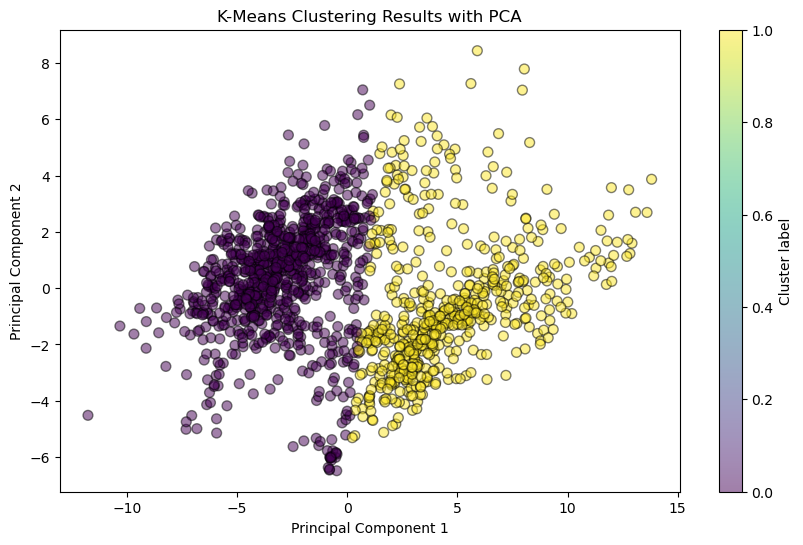

In [39]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib

# トレーニングデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/house_price/train/selected_features.csv'
train_data = pd.read_csv(data_path)

# SalePrice列を除去（必要に応じて使用）
# X_train = train_data.drop(columns=['SalePrice'])
X_train = train_data  # 上記行をコメントアウトし、この行を使用する場合

# スケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# スケーラーの保存
joblib.dump(scaler, 'kmeans_scaler.pkl')

# K-Meansクラスタリング
kmeans = KMeans(n_clusters=2, random_state=42)
train_clusters = kmeans.fit_predict(X_train_scaled)

# K-Meansモデルの保存
joblib.dump(kmeans, 'kmeans_model.pkl')

# 主成分分析で次元削減
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# PCAモデルの保存
joblib.dump(pca, 'kmeans_pca.pkl')

# クラスタラベルをデータフレームに追加
train_data['Cluster'] = train_clusters

# クラスタリング結果を保存
output_path_train = '/Users/hayakawakazue/Downloads/house_price/train/train_clustered.csv'
train_data.to_csv(output_path_train, index=False)

# プロット
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.5)
plt.title('K-Means Clustering Results with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster label')
plt.show()


# エルボー法を実装する

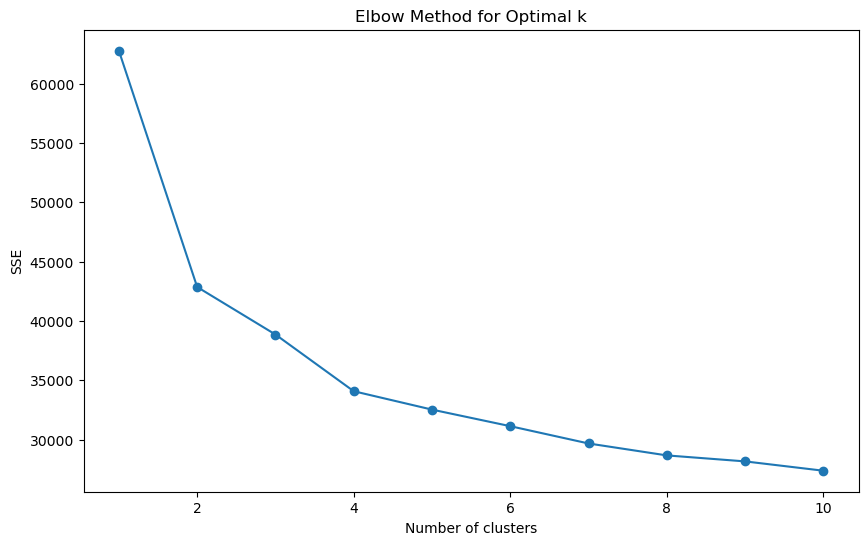

In [41]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/house_price/train/selected_features.csv'
data = pd.read_csv(data_path)

# スケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# エルボー法の実行
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# プロット
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()


# シルエット分析を実行する

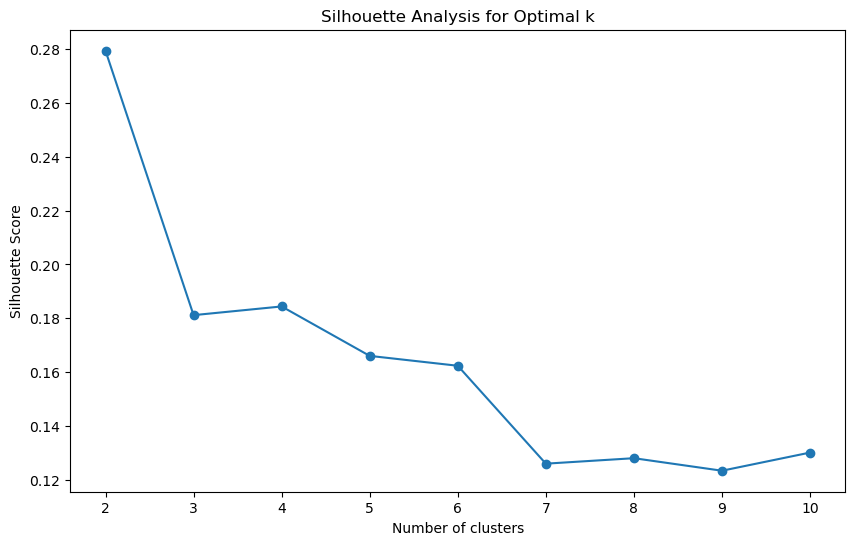

In [43]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/house_price/train/selected_features.csv'
data = pd.read_csv(data_path)

# スケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# シルエット分析の実行
silhouette_scores = []
k_range = range(2, 11)  # シルエットスコアは2以上のクラスタ数で評価する
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    silhouette_scores.append(score)

# プロット
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()


# trainデータセットをクラスタごとに分割する

In [45]:
import pandas as pd

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/house_price/train/train_clustered.csv'
train_data = pd.read_csv(data_path)

# クラスタごとにデータを分割
cluster_0 = train_data[train_data['Cluster'] == 0]
cluster_1 = train_data[train_data['Cluster'] == 1]

# 各クラスタのデータを保存
cluster_0.to_csv('/Users/hayakawakazue/Downloads/house_price/train/cluster_0.csv', index=False)
cluster_1.to_csv('/Users/hayakawakazue/Downloads/house_price/train/cluster_1.csv', index=False)

print("各クラスタのデータが保存されました。")



各クラスタのデータが保存されました。


# testデータセットをクラスタリングする

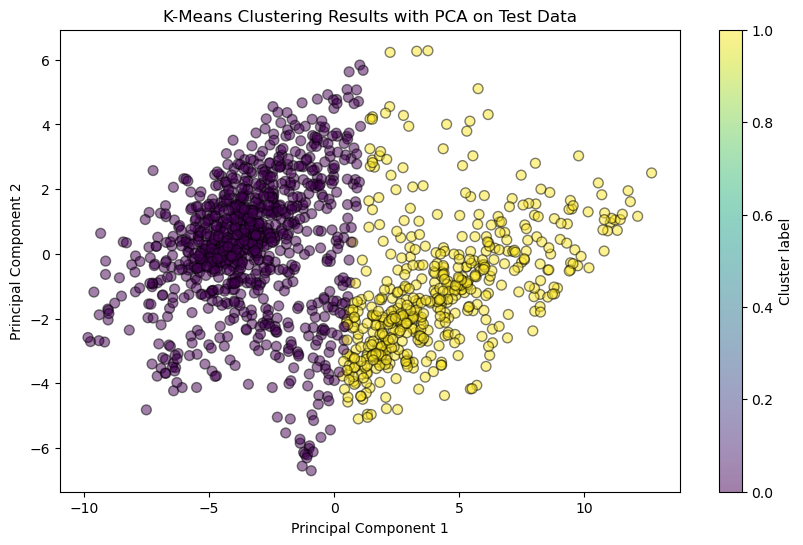

In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import joblib

# スケーラー、PCAモデル、K-Meansモデルの読み込み
scaler = joblib.load('kmeans_scaler.pkl')
pca = joblib.load('kmeans_pca.pkl')
kmeans = joblib.load('kmeans_model.pkl')

# テストデータの読み込み
test_data_path = '/Users/hayakawakazue/Downloads/house_price/test/test_preprocessed.csv'
test_data = pd.read_csv(test_data_path)

# ID列を保持
test_ids = test_data['Id']

# トレーニング時に使用した特徴量リスト
train_data_path = '/Users/hayakawakazue/Downloads/house_price/train/selected_features.csv'
train_data = pd.read_csv(train_data_path)
features = train_data.columns.tolist()

# テストデータに存在しない特徴量をチェックして削除
features_to_use = [feature for feature in features if feature in test_data.columns]

# SalePrice列をテストデータに追加
if 'SalePrice' in features and 'SalePrice' not in test_data.columns:
    test_data['SalePrice'] = 0  # ダミー値を追加
    features_to_use.append('SalePrice')

X_test = test_data[features_to_use]

# スケーリング（テストデータに対してはfit_transformではなくtransformを使用）
X_test_scaled = scaler.transform(X_test)

# PCAの適用
X_test_pca = pca.transform(X_test_scaled)

# K-Meansクラスタリングの適用
test_clusters = kmeans.predict(X_test_scaled)

# クラスタラベルをデータフレームに追加
test_data['Cluster'] = test_clusters

# クラスタリング結果を保存
output_path_test = '/Users/hayakawakazue/Downloads/house_price/test/test_clustered.csv'
test_data.to_csv(output_path_test, index=False)

# クラスタリング結果のプロット
plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_clusters, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.5)
plt.title('K-Means Clustering Results with PCA on Test Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster label')
plt.show()


# testデータセットをクラスタごとに分割する

In [49]:
import pandas as pd

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/house_price/test/test_clustered.csv'
test_data = pd.read_csv(data_path)

# クラスタごとにデータを分割
cluster_0 = test_data[test_data['Cluster'] == 0]
cluster_1 = test_data[test_data['Cluster'] == 1]

# 各クラスタのデータを保存
cluster_0.to_csv('/Users/hayakawakazue/Downloads/house_price/test/test_cluster_0.csv', index=False)
cluster_1.to_csv('/Users/hayakawakazue/Downloads/house_price/test/test_cluster_1.csv', index=False)

print("各クラスタのデータが保存されました。")


各クラスタのデータが保存されました。
